# Reverse Engineering At-Bay Calculator

The goal here is to work backwards trying to figure out how this calculator works. I began by looking at the source, which leads to a minified javascript code. Beautifying and looking at the javascript code shows that the calculations are done on the server-side, so I won't be able to figure it out from viewing the code. 

The next thing I tried was looking at the code in burp suite. This shows the website is submitting the following request:

`
GET /bp/api/gui/v1/financial_exposure/calculate?record_owner=customer_and_employee&num_records=92000&record_type=PHI-PCI&breach_type=error&percent_addr_stored=0&recent_breach=true&network_complexity=low&public_profile=large&security_quality=below&ca_based=true HTTP/1.1
Host: www.at-bay.com
Connection: close
Accept: application/json, text/javascript, */*; q=0.01
DNT: 1
X-Requested-With: XMLHttpRequest
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36
Content-Type: application/json
Referer: https://www.at-bay.com/data-breach-calculator/
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: visid_incap_1608995=1x8GWrW/SBKSl9YR0xz+9yq4AVwAAAAAQUIPAAAAAAD5DjHpx8LIceWTb6lRzS1B; _ga=GA1.2.648618893.1543616556; __insp_uid=3545768712; __insp_wid=1575031163; __insp_nv=false; __insp_targlpu=aHR0cHM6Ly93d3cuYXQtYmF5LmNvbS9kYXRhLWJyZWFjaC1jYWxjdWxhdG9yLw%3D%3D; __insp_targlpt=RGF0YSBCcmVhY2ggQ29zdCBDYWxjdWxhdG9y; __insp_sid=1800059517; incap_ses_982_1608995=0TaFNrzHM08gN7/RUMSgDRlRJVwAAAAA8EkB/bP5I2xDhzzD7g3VjA==; incap_ses_976_1608995=/OR4fR/Kr1H+U/uhVnOLDSZRJVwAAAAAaUkY57OsB21J1atz4q5kzQ==; incap_ses_981_1608995=XlalGKgvqTmLlv2d1DadDZp8JVwAAAAAFTuXMCruMiw3s2m80hmdMA==; _gid=GA1.2.168275885.1546380482; incap_ses_444_1608995=4J5rJDY+aAeE2nGH1GgpBsHkK1wAAAAAc3CNWkWXT/eHas0k3gyf9w==; __insp_pad=3; __insp_slim=1546380711791
`

Which results in the following response:

`HTTP/1.1 200 OK
Server: nginx
Date: Tue, 01 Jan 2019 22:12:43 GMT
Content-Type: application/json
Content-Length: 321
Connection: close
Strict-Transport-Security: max-age=31536000;
X-Iinfo: 4-172892599-172892604 NNNN CT(37 37 0) RT(1546380763664 20) q(0 0 1 -1) r(2 2) U5
X-CDN: Incapsula

{"result": {"breach_coach": 25000, "call_center": 66000, "class_action_fines_and_defense": 5400000, "credit_monitoring": 120000, "crisis_management": 100000, "forensics": 90000, "notification": 2800, "pci_fines": 2800000, "regulatory_fines_and_defense": 6600000}, "total": 15203800, "cost_per_record": 165.2586956521739}`

This will show me all the information that I need to know. The url `/bp/api/gui/v1/financial_exposure/calculate?record_owner=customer_and_employee&num_records=92000&record_type=PHI-PCI&breach_type=error&percent_addr_stored=100&recent_breach=true&network_complexity=high&public_profile=large&security_quality=above&ca_based=true
` in the request shows that the variables we need to modify are `record_owner, num_records, record_type, breach_type, percent_addr_stored, recent_breach, network_complexity, public_profile, security_quality, and ca_based`, corresponding to the questions in the order they are asked on the calculator.

Through looking at the requests sent when changing values, we can see that the possible values for each of these are:

`record_owner: employee_only, customer_and_employee
num_records: 1-100000000
record_type: PII, PHI, PCI, PCI-PHI
breach_type: error, theft, hack
percent_addr_stored: 0-100
recent_breach: true, false
network_complexity: low, medium, high
public_profile: small, medium, large
security_quality: below, average, above
ca_based: true, false`

In [2]:
import urllib3
from bs4 import BeautifulSoup


rolist = ['employee_only', 'customer_and_employee']
nrlist = [1, 10000, 100000000]
rtlist = ['PII', 'PHI', 'PCI', 'PHI-PCI']
btlist = ['error', 'theft', 'hack']
paslist = [1, 50, 100]
rblist = ['true', 'false']
nclist = ['low', 'medium', 'high']
pplist = ['small', 'medium', 'large']
sqlist = ['below', 'average', 'above']
calist = ['true', 'false']

Start by trying every combination of discrete values with three options for each of those which accept many integers. The following creates 23,328 lines containing each possible combination of variables.

In [4]:
i=0
for ro in rolist:
    for nr in nrlist:
        for rt in rtlist:
            for bt in btlist:
                for pas in paslist:
                    for rb in rblist:
                        for nc in nclist:
                            for pp in pplist:
                                for sq in sqlist:
                                    for ca in calist:
                                        #print(str(i)+ro+str(nr)+rt+bt+str(pas)+rb+nc+pp+sq+ca)
                                        i+=1
print(i)


23328


It doesn't make any sense to try to work with 23,328 combinations. I wouldn't know what to do with the results once I got them. I will try rebuilding the calculator systematically and piece by piece.

I'll start with the first three variables, which they say on the calculator itself should give you a rough estimate of the overall cost before you answer the rest of the information.

Let's try every combination of rolist, rtlist, and 3 values for nrlist and see what we get returned.

We will take out all of the extraneous information and condense the results into a dataframe which will be easy to work with. 

In [5]:
for ro in rolist:
    for nr in nrlist:
        for rt in rtlist:
            url = 'https://www.at-bay.com/bp/api/gui/v1/financial_exposure/calculate?record_owner='+ro+'&num_records='+str(nr)+'&record_type='+rt
            http = urllib3.PoolManager()
            response = http.request('GET', url)
            soup = BeautifulSoup(response.data, "lxml")
            f = open('test.csv', "a")
            soupstr = str(soup)
            pfixsoupstr = soupstr.replace('<html><body><p>{"result": {','').replace(' "call_center": ','').replace('"breach_coach": ','').replace(' "class_action_fines_and_defense": ','').replace(' "credit_monitoring": ','').replace(' "crisis_management": ','').replace(' "forensics": ','').replace(' "notification": ','').replace(' "pci_fines": ','').replace(' "regulatory_fines_and_defense": ','').replace('}, "total": ',',').replace(' "cost_per_record": ', '').replace('}','').replace('\n','').replace('</p></body></html>','')
            f.write(ro+','+str(nr)+','+rt+','+pfixsoupstr+"\n")
            f.close()           

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is be

Recall that the response has the fields `"result": {"breach_coach": 25000, "call_center": 66000, "class_action_fines_and_defense": 5400000, "credit_monitoring": 120000, "crisis_management": 100000, "forensics": 90000, "notification": 2800, "pci_fines": 2800000, "regulatory_fines_and_defense": 6600000}, "total": 15203800, "cost_per_record": 165.2586956521739`, which I will label in the dataframe as `bc, cc, cafd, crem, crim,for,not,pci,reg,total,cpr`

In [7]:
import pandas as pd

df = pd.read_csv('test.csv',names=['ro','nr','rt','bc', 'cc', 'cafd', 'crem', 'crim','for','not','pcif','reg','total','cpr'])

df

,ro,nr,rt,bc,cc,cafd,crem,crim,for,not,pcif,reg,total,cpr
0,employee_only,1,PII,25000,1300,0,10,30000,60000,2800,0,280000,399110,399110.0000
1,employee_only,1,PHI,25000,1300,0,10,40000,60000,2800,0,530000,659110,659110.0000
2,employee_only,1,PCI,25000,1300,0,10,20000,120000,2800,75000,280000,524110,524110.0000
3,employee_only,1,PHI-PCI,25000,1300,0,10,40000,120000,2800,75000,530000,794110,794110.0000
4,employee_only,10000,PII,50000,6100,650000,74000,53000,60000,15000,0,280000,1188100,118.8100
5,employee_only,10000,PHI,50000,6100,880000,89000,70000,60000,15000,0,530000,1700100,170.0100
6,employee_only,10000,PCI,50000,6100,650000,59000,35000,120000,15000,380000,280000,1595100,159.5100
7,employee_only,10000,PHI-PCI,50000,6100,880000,89000,70000,120000,15000,380000,530000,2140100,214.0100
8,employee_only,100000000,PII,750000,88000000,18000000,490000000,300000,750000,56000000,0,20000000,673800000,6.7380
9,employee_only,100000000,PHI,750000,88000000,18000000,490000000,400000,750000,56000000,0,41000000,694900000,6.9490


In [8]:
def ispci(df):
    if df['rt'] == 'PCI':
        return 'Yes'
    elif df['rt'] == 'PHI-PCI':
        return 'Yes'
    else:
        return 'No'

df['ispci'] = df.apply(ispci, axis=1)

In [9]:
def isphi(df):
    if df['rt'] == 'PHI':
        return 'Yes'
    elif df['rt'] == 'PHI-PCI':
        return 'Yes'
    else:
        return 'No'

df['isphi'] = df.apply(isphi, axis=1)

In [10]:
newdf = df.drop(columns=['rt'])
newdf

,ro,nr,bc,cc,cafd,crem,crim,for,not,pcif,reg,total,cpr,ispci,isphi
0,employee_only,1,25000,1300,0,10,30000,60000,2800,0,280000,399110,399110.0000,No,No
1,employee_only,1,25000,1300,0,10,40000,60000,2800,0,530000,659110,659110.0000,No,Yes
2,employee_only,1,25000,1300,0,10,20000,120000,2800,75000,280000,524110,524110.0000,Yes,No
3,employee_only,1,25000,1300,0,10,40000,120000,2800,75000,530000,794110,794110.0000,Yes,Yes
4,employee_only,10000,50000,6100,650000,74000,53000,60000,15000,0,280000,1188100,118.8100,No,No
5,employee_only,10000,50000,6100,880000,89000,70000,60000,15000,0,530000,1700100,170.0100,No,Yes
6,employee_only,10000,50000,6100,650000,59000,35000,120000,15000,380000,280000,1595100,159.5100,Yes,No
7,employee_only,10000,50000,6100,880000,89000,70000,120000,15000,380000,530000,2140100,214.0100,Yes,Yes
8,employee_only,100000000,750000,88000000,18000000,490000000,300000,750000,56000000,0,20000000,673800000,6.7380,No,No
9,employee_only,100000000,750000,88000000,18000000,490000000,400000,750000,56000000,0,41000000,694900000,6.9490,No,Yes


going back in time to before changing that variable.. since im not exactly sure what the point of that was anyway.|

In [11]:
pr_df = df[['bc','cc','cafd', 'crem', 'crim','for','not','pcif','reg']].div(df.nr, axis=0)

lab_df = df[['ro','rt','nr','cpr']]

pr_df = pr_df.join(lab_df)
pr_df



,bc,cc,cafd,crem,crim,for,not,pcif,reg,ro,rt,nr,cpr
0,25000.0000,1300.00,0.00,10.00,30000.000,60000.0000,2800.00,0.0,280000.00,employee_only,PII,1,399110.0000
1,25000.0000,1300.00,0.00,10.00,40000.000,60000.0000,2800.00,0.0,530000.00,employee_only,PHI,1,659110.0000
2,25000.0000,1300.00,0.00,10.00,20000.000,120000.0000,2800.00,75000.0,280000.00,employee_only,PCI,1,524110.0000
3,25000.0000,1300.00,0.00,10.00,40000.000,120000.0000,2800.00,75000.0,530000.00,employee_only,PHI-PCI,1,794110.0000
4,5.0000,0.61,65.00,7.40,5.300,6.0000,1.50,0.0,28.00,employee_only,PII,10000,118.8100
5,5.0000,0.61,88.00,8.90,7.000,6.0000,1.50,0.0,53.00,employee_only,PHI,10000,170.0100
6,5.0000,0.61,65.00,5.90,3.500,12.0000,1.50,38.0,28.00,employee_only,PCI,10000,159.5100
7,5.0000,0.61,88.00,8.90,7.000,12.0000,1.50,38.0,53.00,employee_only,PHI-PCI,10000,214.0100
8,0.0075,0.88,0.18,4.90,0.003,0.0075,0.56,0.0,0.20,employee_only,PII,100000000,6.7380
9,0.0075,0.88,0.18,4.90,0.004,0.0075,0.56,0.0,0.41,employee_only,PHI,100000000,6.9490


In [12]:
pr_ie = pr_df.loc[(pr_df["ro"] == 'employee_only') & (pr_df["rt"] == 'PII')]
pr_iu = pr_df.loc[(pr_df["ro"] == 'customer_and_employee') & (pr_df["rt"] == 'PII')]
pr_he = pr_df.loc[(pr_df["ro"] == 'employee_only') & (pr_df["rt"] == 'PHI')]
pr_hu = pr_df.loc[(pr_df["ro"] == 'customer_and_employee') & (pr_df["rt"] == 'PHI')]
pr_ce = pr_df.loc[(pr_df["ro"] == 'employee_only') & (pr_df["rt"] == 'PCI')]
pr_cu = pr_df.loc[(pr_df["ro"] == 'customer_and_employee') & (pr_df["rt"] == 'PCI')]
pr_hce = pr_df.loc[(pr_df["ro"] == 'employee_only') & (pr_df["rt"] == 'PHI-PCI')]
pr_hcu = pr_df.loc[(pr_df["ro"] == 'customer_and_employee') & (pr_df["rt"] == 'PHI-PCI')]

In [23]:
lvls =['ie', 'iu','he', 'hu','ce', 'cu','hce', 'hcu']
blvls = ['bc', 'cc','cafd', 'crem','crim', 'for','not', 'pcif', 'reg', 'cpr']

def do_thing(l,b):
    a = "pr_"+l+"_"+b+" = {'1': pr_"+l+"['"+b+"'].iloc[0],'10000': pr_"+l+"['"+b+"'].iloc[1],'1000000000': pr_"+l+"['"+b+"'].iloc[2]}"
    a
    print(a)

for l in lvls:
    for b in blvls:
        do_thing(l,b)
# how to get this so it actually runs rather than just printing out all the lines?????

pr_ie_bc = {'1': pr_ie['bc'].iloc[0],'10000': pr_ie['bc'].iloc[1],'1000000000': pr_ie['bc'].iloc[2]}
pr_ie_cc = {'1': pr_ie['cc'].iloc[0],'10000': pr_ie['cc'].iloc[1],'1000000000': pr_ie['cc'].iloc[2]}
pr_ie_cafd = {'1': pr_ie['cafd'].iloc[0],'10000': pr_ie['cafd'].iloc[1],'1000000000': pr_ie['cafd'].iloc[2]}
pr_ie_crem = {'1': pr_ie['crem'].iloc[0],'10000': pr_ie['crem'].iloc[1],'1000000000': pr_ie['crem'].iloc[2]}
pr_ie_crim = {'1': pr_ie['crim'].iloc[0],'10000': pr_ie['crim'].iloc[1],'1000000000': pr_ie['crim'].iloc[2]}
pr_ie_for = {'1': pr_ie['for'].iloc[0],'10000': pr_ie['for'].iloc[1],'1000000000': pr_ie['for'].iloc[2]}
pr_ie_not = {'1': pr_ie['not'].iloc[0],'10000': pr_ie['not'].iloc[1],'1000000000': pr_ie['not'].iloc[2]}
pr_ie_pcif = {'1': pr_ie['pcif'].iloc[0],'10000': pr_ie['pcif'].iloc[1],'1000000000': pr_ie['pcif'].iloc[2]}
pr_ie_reg = {'1': pr_ie['reg'].iloc[0],'10000': pr_ie['reg'].iloc[1],'1000000000': pr_ie['reg'].iloc[2]}
pr_ie_cpr = {'1': pr_ie['cpr'].iloc[0],'10000':

In [24]:
pr_hcu_crim

{'1': 40000.0, '10000': 7.0, '1000000000': 0.004}

In [31]:
def ready_for_graph(l,b):
    a = "pr_"+l+"_"+b+"_names = list(pr_"+l+"_"+b+".keys())"
    c = "pr_"+l+"_"+b+"_values = list(pr_"+l+"_"+b+".values())"
    print(a+'\n'+c)

for x in lvls:
    for y in blvls:
        ready_for_graph(x,y)

pr_ie_bc_names = list(pr_ie_bc.keys())
pr_ie_bc_values = list(pr_ie_bc.values())
pr_ie_cc_names = list(pr_ie_cc.keys())
pr_ie_cc_values = list(pr_ie_cc.values())
pr_ie_cafd_names = list(pr_ie_cafd.keys())
pr_ie_cafd_values = list(pr_ie_cafd.values())
pr_ie_crem_names = list(pr_ie_crem.keys())
pr_ie_crem_values = list(pr_ie_crem.values())
pr_ie_crim_names = list(pr_ie_crim.keys())
pr_ie_crim_values = list(pr_ie_crim.values())
pr_ie_for_names = list(pr_ie_for.keys())
pr_ie_for_values = list(pr_ie_for.values())
pr_ie_not_names = list(pr_ie_not.keys())
pr_ie_not_values = list(pr_ie_not.values())
pr_ie_pcif_names = list(pr_ie_pcif.keys())
pr_ie_pcif_values = list(pr_ie_pcif.values())
pr_ie_reg_names = list(pr_ie_reg.keys())
pr_ie_reg_values = list(pr_ie_reg.values())
pr_ie_cpr_names = list(pr_ie_cpr.keys())
pr_ie_cpr_values = list(pr_ie_cpr.values())
pr_iu_bc_names = list(pr_iu_bc.keys())
pr_iu_bc_values = list(pr_iu_bc.values())
pr_iu_cc_names = list(pr_iu_cc.keys())
pr_iu_cc_values = list

In [59]:
def plot_it(l,b):
    ihc_val = 0
    if "c" in l:
        ihc_val = 1
        if "h" in l:
            ihc_val = 3
    else:
        ihc_val = 0
        if "h" in l:
            ihc_val = 2
                
    if "u" in l:
        ue_val = 1
    else:
        ue_val = 0
    print("axs["+str(ue_val)+","+str(ihc_val)+"].plot(pr_"+l+"_"+b+"_names, pr_"+l+"_"+b+"_values)")
    
def print_title(l,b):
    ihc_val = 0
    if "c" in l:
        ihc_val = 1
        if "h" in l:
            ihc_val = 3
    else:
        ihc_val = 0
        if "h" in l:
            ihc_val = 2
                
    if "u" in l:
        ue_val = 1
    else:
        ue_val = 0
        
    ihc_status = 'No PCI/PHI'
    if "c" in l:
        ihc_status = 'PCI'
        if "h" in l:
            ihc_status = 'PCI & PHI'
    else:
        ihc_status = 'No PCI/PHI'
        if "h" in l:
            ihc_status = 'PHI'
    
    eu_status = 'E'
    if "u" in l:
        eu_status = 'C/E'
    else:
        eu_status = 'E'
        
    print("axs["+str(ue_val)+","+str(ihc_val)+"].set_title('"+ihc_status+"', '"+eu_status+"')")
            
for x in lvls:
    for y in blvls:
        plot_it(x,y)
    print_title(x,y)
    

axs[0,0].plot(pr_ie_bc_names, pr_ie_bc_values)
axs[0,0].plot(pr_ie_cc_names, pr_ie_cc_values)
axs[0,0].plot(pr_ie_cafd_names, pr_ie_cafd_values)
axs[0,0].plot(pr_ie_crem_names, pr_ie_crem_values)
axs[0,0].plot(pr_ie_crim_names, pr_ie_crim_values)
axs[0,0].plot(pr_ie_for_names, pr_ie_for_values)
axs[0,0].plot(pr_ie_not_names, pr_ie_not_values)
axs[0,0].plot(pr_ie_pcif_names, pr_ie_pcif_values)
axs[0,0].plot(pr_ie_reg_names, pr_ie_reg_values)
axs[0,0].plot(pr_ie_cpr_names, pr_ie_cpr_values)
axs[0,0].set_title('No PCI/PHI', 'E')
axs[1,0].plot(pr_iu_bc_names, pr_iu_bc_values)
axs[1,0].plot(pr_iu_cc_names, pr_iu_cc_values)
axs[1,0].plot(pr_iu_cafd_names, pr_iu_cafd_values)
axs[1,0].plot(pr_iu_crem_names, pr_iu_crem_values)
axs[1,0].plot(pr_iu_crim_names, pr_iu_crim_values)
axs[1,0].plot(pr_iu_for_names, pr_iu_for_values)
axs[1,0].plot(pr_iu_not_names, pr_iu_not_values)
axs[1,0].plot(pr_iu_pcif_names, pr_iu_pcif_values)
axs[1,0].plot(pr_iu_reg_names, pr_iu_reg_values)
axs[1,0].plot(pr_iu_cpr

In [75]:
pr_ie_bc_names

['1', '10000', '1000000000']

In [76]:
pr_ie_bc_values

[25000.0, 5.0, 0.0075]

NameError: name 'pr_cu_ccb_values' is not defined

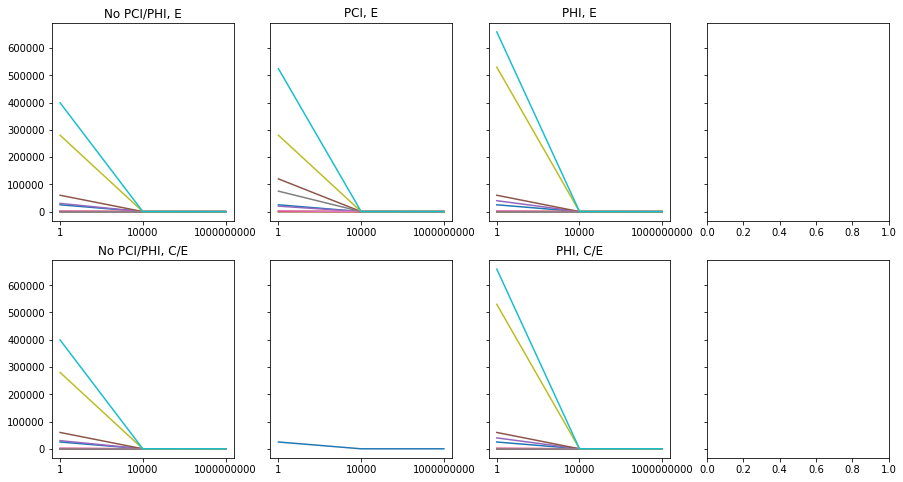

In [77]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,4, figsize=(15, 8), sharey=True)



axs[0,0].plot(pr_ie_bc_names, pr_ie_bc_values)
axs[0,0].plot(pr_ie_cc_names, pr_ie_cc_values)
axs[0,0].plot(pr_ie_cafd_names, pr_ie_cafd_values)
axs[0,0].plot(pr_ie_crem_names, pr_ie_crem_values)
axs[0,0].plot(pr_ie_crim_names, pr_ie_crim_values)
axs[0,0].plot(pr_ie_for_names, pr_ie_for_values)
axs[0,0].plot(pr_ie_not_names, pr_ie_not_values)
axs[0,0].plot(pr_ie_pcif_names, pr_ie_pcif_values)
axs[0,0].plot(pr_ie_reg_names, pr_ie_reg_values)
axs[0,0].plot(pr_ie_cpr_names, pr_ie_cpr_values)
axs[0,0].set_title('No PCI/PHI, E')
axs[1,0].plot(pr_iu_bc_names, pr_iu_bc_values)
axs[1,0].plot(pr_iu_cc_names, pr_iu_cc_values)
axs[1,0].plot(pr_iu_cafd_names, pr_iu_cafd_values)
axs[1,0].plot(pr_iu_crem_names, pr_iu_crem_values)
axs[1,0].plot(pr_iu_crim_names, pr_iu_crim_values)
axs[1,0].plot(pr_iu_for_names, pr_iu_for_values)
axs[1,0].plot(pr_iu_not_names, pr_iu_not_values)
axs[1,0].plot(pr_iu_pcif_names, pr_iu_pcif_values)
axs[1,0].plot(pr_iu_reg_names, pr_iu_reg_values)
axs[1,0].plot(pr_iu_cpr_names, pr_iu_cpr_values)
axs[1,0].set_title('No PCI/PHI, C/E')
axs[0,2].plot(pr_he_bc_names, pr_he_bc_values)
axs[0,2].plot(pr_he_cc_names, pr_he_cc_values)
axs[0,2].plot(pr_he_cafd_names, pr_he_cafd_values)
axs[0,2].plot(pr_he_crem_names, pr_he_crem_values)
axs[0,2].plot(pr_he_crim_names, pr_he_crim_values)
axs[0,2].plot(pr_he_for_names, pr_he_for_values)
axs[0,2].plot(pr_he_not_names, pr_he_not_values)
axs[0,2].plot(pr_he_pcif_names, pr_he_pcif_values)
axs[0,2].plot(pr_he_reg_names, pr_he_reg_values)
axs[0,2].plot(pr_he_cpr_names, pr_he_cpr_values)
axs[0,2].set_title('PHI, E')
axs[1,2].plot(pr_hu_bc_names, pr_hu_bc_values)
axs[1,2].plot(pr_hu_cc_names, pr_hu_cc_values)
axs[1,2].plot(pr_hu_cafd_names, pr_hu_cafd_values)
axs[1,2].plot(pr_hu_crem_names, pr_hu_crem_values)
axs[1,2].plot(pr_hu_crim_names, pr_hu_crim_values)
axs[1,2].plot(pr_hu_for_names, pr_hu_for_values)
axs[1,2].plot(pr_hu_not_names, pr_hu_not_values)
axs[1,2].plot(pr_hu_pcif_names, pr_hu_pcif_values)
axs[1,2].plot(pr_hu_reg_names, pr_hu_reg_values)
axs[1,2].plot(pr_hu_cpr_names, pr_hu_cpr_values)
axs[1,2].set_title('PHI, C/E')
axs[0,1].plot(pr_ce_bc_names, pr_ce_bc_values)
axs[0,1].plot(pr_ce_cc_names, pr_ce_cc_values)
axs[0,1].plot(pr_ce_cafd_names, pr_ce_cafd_values)
axs[0,1].plot(pr_ce_crem_names, pr_ce_crem_values)
axs[0,1].plot(pr_ce_crim_names, pr_ce_crim_values)
axs[0,1].plot(pr_ce_for_names, pr_ce_for_values)
axs[0,1].plot(pr_ce_not_names, pr_ce_not_values)
axs[0,1].plot(pr_ce_pcif_names, pr_ce_pcif_values)
axs[0,1].plot(pr_ce_reg_names, pr_ce_reg_values)
axs[0,1].plot(pr_ce_cpr_names, pr_ce_cpr_values)
axs[0,1].set_title('PCI, E')
axs[1,1].plot(pr_cu_bc_names, pr_cu_bc_values)
axs[1,1].plot(pr_cu_cc_names, pr_cu_ccb_values)
axs[1,1].plot(pr_cu_cafd_names, pr_cu_cafd_values)
axs[1,1].plot(pr_cu_crem_names, pr_cu_crem_values)
axs[1,1].plot(pr_cu_crim_names, pr_cu_crim_values)
axs[1,1].plot(pr_cu_for_names, pr_cu_for_values)
axs[1,1].plot(pr_cu_not_names, pr_cu_not_values)
axs[1,1].plot(pr_cu_pcif_names, pr_cu_pcif_values)
axs[1,1].plot(pr_cu_reg_names, pr_cu_reg_values)
axs[1,1].plot(pr_cu_cpr_names, pr_cu_cpr_values)
axs[1,1].set_title('PCI, C/E')
axs[0,3].plot(pr_hce_bc_names, pr_hce_bc_values)
axs[0,3].plot(pr_hce_cc_names, pr_hce_cc_values)
axs[0,3].plot(pr_hce_cafd_names, pr_hce_cafd_values)
axs[0,3].plot(pr_hce_crem_names, pr_hce_crem_values)
axs[0,3].plot(pr_hce_crim_names, pr_hce_crim_values)
axs[0,3].plot(pr_hce_for_names, pr_hce_for_values)
axs[0,3].plot(pr_hce_not_names, pr_hce_not_values)
axs[0,3].plot(pr_hce_pcif_names, pr_hce_pcif_values)
axs[0,3].plot(pr_hce_reg_names, pr_hce_reg_values)
axs[0,3].plot(pr_hce_cpr_names, pr_hce_cpr_values)
axs[0,3].set_title('PCI & PHI, E')
axs[1,3].plot(pr_hcu_bc_names, pr_hcu_bc_values)
axs[1,3].plot(pr_hcu_cc_names, pr_hcu_cc_values)
axs[1,3].plot(pr_hcu_cafd_names, pr_hcu_cafd_values)
axs[1,3].plot(pr_hcu_crem_names, pr_hcu_crem_values)
axs[1,3].plot(pr_hcu_crim_names, pr_hcu_crim_values)
axs[1,3].plot(pr_hcu_for_names, pr_hcu_for_values)
axs[1,3].plot(pr_hcu_not_names, pr_hcu_not_values)
axs[1,3].plot(pr_hcu_pcif_names, pr_hcu_pcif_values)
axs[1,3].plot(pr_hcu_reg_names, pr_hcu_reg_values)
axs[1,3].plot(pr_hcu_cpr_names, pr_hcu_cpr_values)
axs[1,3].set_title('PCI & PHI, C/E')

In [71]:
def get_dict_for_query(df, roval, rtval, column_name):
    sub_df = df.loc[(df["ro"] == roval) & (df["rt"] == rtval)]
    keys = sub_df['nr'].values
    values = sub_df[column_name].values
    return dict(zip(keys, values))

In [73]:
get_dict_for_query(df,'employee_only', 'PII', 'reg')

{1: 280000, 10000: 280000, 100000000: 20000000}